# RANDOM WALKS WITH `ndarray`s

## 1D Random Walk
The most elementary example of a random walk is the one on the integer number line, $\mathbb {Z}$, that starts in 0 and at each step moves +1 or −1 with equal probability.

Here is a typical C-like 1D solution.
```Python
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

Nsteps = 10000

x = 0
position = [x]

# Loop over...
for i in range(Nsteps):
    # ...coin flips
    if np.random.uniform(0., 1.) < 0.5:
        step = -1
    else:
        step = 1
    # Move
    x += step
    # Track all moves
    position.append(x)
    
plt.plot(position[:Nsteps])
plt.grid()
plt.xlabel('Step')
plt.ylabel('Position')
```

### Using arrays instead of lists

Note that the position along the walk is the cumulative sum of random numbers: we can use this to convert the problem to using arrays only.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Nsteps = 10000

**1. Randomly draw -1 or 1 for all `Nsteps` steps at once.**  Think of it as a `Nsteps` coin tosses.

In [4]:
options = np.array((-1, 1))
steps = np.random.choice(options, size=Nsteps)
print(steps)

[-1  1 -1 ... -1  1  1]


There should (roughly) be 50% 1's and 50% -1's.  We can check this by summing over a boolean array and then divide by `Nsteps`.

In [5]:
print((steps==1).sum()/Nsteps)
print((steps<1).sum()/Nsteps)

0.4993
0.5007


**2. Compute the cumulative sum of random numbers.**  The cumulative sum on an `ndarray` sums all values in cells before a given position. We remember to prepend the starting point.

In [6]:
walk = steps.cumsum()
print(walk)

walk = np.insert(walk, 0, 0)
Nsteps = Nsteps+1
print(walk)

print(steps.sum())
print(type(walk))
walk.shape

[ -1   0  -1 ... -16 -15 -14]
[  0  -1   0 ... -16 -15 -14]
-14
<class 'numpy.ndarray'>


(10001,)

Text(0.5, 1.0, '1D Random Walk with 10000 steps')

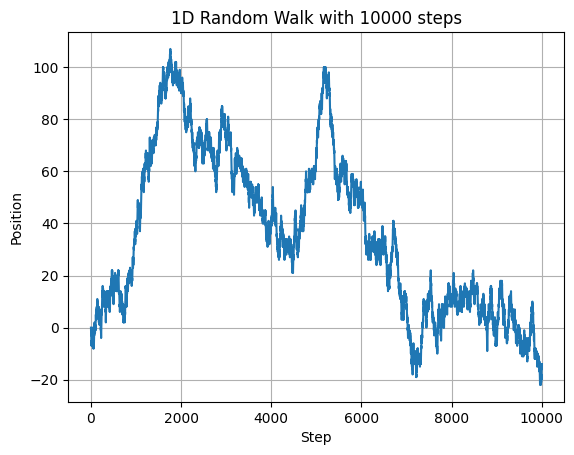

In [7]:
plt.plot(walk)
plt.grid()
plt.xlabel('Step')
plt.ylabel('Position')
plt.title('1D Random Walk with {0} steps'.format(Nsteps-1))

### Finding information about the walk and performing an analysis is now trivial

Maximum/minimum position with `max()`/`min()`:

In [8]:
print(walk.max())
print(walk.min())

107
-22


`argmax()`/`argmin()` provides the **first** index where the `max()`/`min()` value occured:

In [9]:
print(walk.argmax())
print(walk[walk.argmax()]==walk.max())

print(walk.argmin())
print(walk[walk.argmin()]==walk.min())

1761
True
9960
True


Location (positive or negative) with the largest distance from the starting point ($x=0$), i.e., $\max_i|x_i|$:

In [10]:
print(np.abs(walk).max())
print(np.abs(walk).argmax())

107
1761


Finding if a given distance, e.g., 20 is ever reached:

In [11]:
x0 = 20
(np.abs(walk)==x0).max()

True

In a boolean array, `max()` corresponds to `True` (if it is in the array), so the distance `x0` is reached and `argmax()` will return the **first** time the particle reaches it.

In [12]:
(np.abs(walk)==x0).argmax()

460

With the `where()` method, we can find **all** crossings of distance `x0`:

In [13]:
np.where(np.abs(walk)==x0)[0]

array([ 460,  462,  468,  470,  474,  528,  534,  536,  542,  544,  572,
        600,  602,  606,  612,  828,  830,  834,  836,  838,  840,  848,
        850,  852,  856,  862,  864,  878,  882,  886,  888,  890,  894,
        896,  898,  918, 6564, 6566, 6578, 6580, 6594, 6596, 6598, 6606,
       6608, 6622, 6636, 6638, 6642, 6816, 7532, 7534, 7538, 7540, 8044,
       8046, 8468, 8470, 8472, 8474, 8478, 8480, 9958, 9964, 9974, 9980,
       9982, 9984, 9986, 9990])

We can therefore also check how many times and when poistions `walk.max()` and `walk.min()` are reached:

In [14]:
print(np.where(walk==walk.max())[0])
print(np.where(walk==walk.min())[0])

[1761]
[9960 9962 9976 9978]


### An animation of the walk

<IPython.core.display.Javascript object>


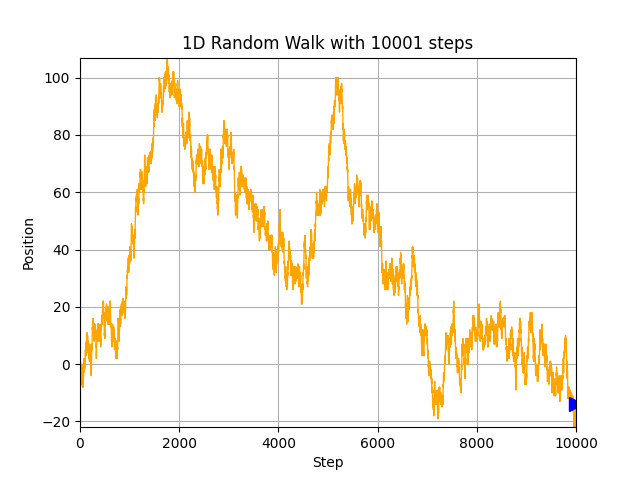

In [15]:
%matplotlib notebook

import matplotlib.animation as animation

# Create a figure object
fig = plt.figure()

# Add subplot (just 1) and set x and y limits based on data.
# 111 means "1x1 grid, 1st subplot".
# ax is the object containing objects to be plotted.
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, Nsteps), ylim=(walk.min(), walk.max()))
ax.grid()
ax.set_xlabel('Step')
ax.set_ylabel('Position')
plt.title('1D Random Walk with {0} steps'.format(Nsteps))

# 1. Plot the initial state of the plot
i = 0
path, *_ = ax.plot(i, walk[i], '-', lw=1, color='orange')
walker, *_ = ax.plot(i, walk[i], '>', lw=2, ms=10, color='blue')

# 2. Function to refresh objects in the plot
def refresh(i):
    # Draw the line from 0th -> i-th position
    path.set_data(range(i), walk[:i])
    # Draw the walker ONLY at the i-th position
    walker.set_data(i, walk[i])
    # Return a tuple
    return path, walker

# 3. Call the FuncAnimation function to redraw the 'fig' object using the 'refresh' function
ani = animation.FuncAnimation(fig, refresh, np.arange(1, Nsteps), interval=0.01, blit=True, repeat=False)

# With %matplotlib notebook, the following line is enough on my machine
plt.show()

# Here is the rendering that makes the animation work on Colab
# (and possibly other machines)
#from matplotlib import rc
# Try html='jshtml' if html='html5' fails
#rc('animation', html='html5')
#ani

## Simulating many random walks at once

We now want to simulate `Nexp` random walks and study statistics about the number of crossings, maximum distance, etc. Instead of using nested loops, we simply use 2D arrays to keep track of all `Nexp` experiments.

The only place where we change the code is the extraction of random numbers to decide the steps of the random walks, i.e., the call to `numpy.random.choice`.

In [16]:
import numpy as np
import matplotlib.pyplot as plt

Nexp = 1000
Nsteps = 1000
# To experiment with adding Gaussian noise, change the value below
Noise = 0

options = np.array((-1, 1))
steps = np.random.choice(options, size=(Nexp, Nsteps)) + Noise * np.random.standard_normal((Nexp, Nsteps))
print(steps.shape)

(1000, 1000)


We call `cumsum(axis=1)` to sum (cumulatively) over the dimension 1, which represents the steps: formally this is known as the `axis` (you can omit `axis=` from the argument of `cumsum`).  We can think of these as the "columns" for a 2D array.  Recall that each "row" represents an experiment. The columns are the draws or steps for a given experiment, so by summing over the columns, we obtain the random walk for each experiment.

We remember to prepend the starting point.

In [17]:
walks = steps.cumsum(axis=1)
print(walks.shape)


walks = np.insert(walks, 0, 0, axis=1)
Nsteps = Nsteps+1
print(walks.shape)

walks

(1000, 1000)
(1000, 1001)


array([[  0.,  -1.,  -2., ...,  18.,  17.,  16.],
       [  0.,  -1.,   0., ...,  58.,  57.,  58.],
       [  0.,  -1.,  -2., ...,   8.,   9.,  10.],
       ...,
       [  0.,   1.,   0., ..., -60., -59., -58.],
       [  0.,   1.,   0., ...,   8.,   7.,   8.],
       [  0.,   1.,   0., ...,  -8.,  -9.,  -8.]])

The maximum distance from the origin, i.e., the starting point, ever reached in all experiments is:

In [18]:
np.abs(walks).max()

115.0

We can also find out the **maximum distance for each experiment**. This is done by using the [`numpy.amax`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.amax.html) function. We want to find the maximum along columns (`axis=1`) for each experiment (row, or `axis=0`).

In [19]:
max_experiment = np.amax(np.abs(walks), 1)
print(max_experiment.shape)

(1000,)


As a sanity check, we see that the maximum distance across experiments is the same as the value returned by `np.abs(walks).max()`:

In [20]:
print("Max ever: {0}. This occurred in experiment: {1}".format(
    max_experiment.max(), max_experiment.argmax())
     )

np.abs(walks).max()

Max ever: 115.0. This occurred in experiment: 527


115.0

The following tells us in which experiment(s) it was reached:

In [21]:
np.where(max_experiment==max_experiment.max())

(array([527]),)

Similarly the smallest maximum distance ever reached is:

In [22]:
max_experiment.min()

13.0

This occured in experiment(s):

In [23]:
np.where(max_experiment==max_experiment.min())

(array([232, 739]),)

Histogram of the maximum distance reached:

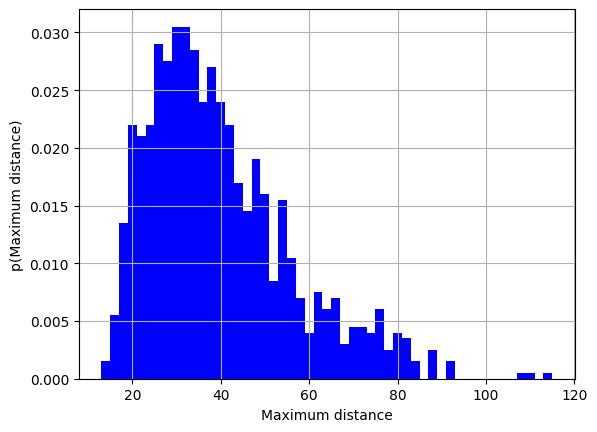

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
n, bins, patches = plt.hist(max_experiment, bins=int((max_experiment.max() - max_experiment.min())/2),
                            facecolor='blue', density=True, log=False)

plt.grid()
plt.xlabel('Maximum distance')
plt.ylabel('p(Maximum distance)');

Histogram of the final position reached:

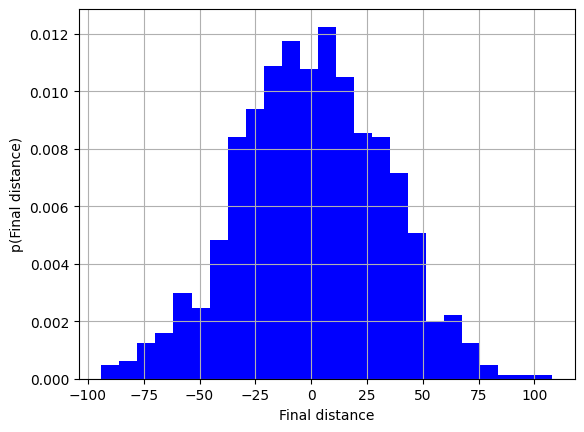

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
n, bins, patches = plt.hist(walks[:,-1], bins=25, facecolor='blue', density=True, log=False)

plt.grid()
plt.xlabel('Final distance')
plt.ylabel('p(Final distance)');

### Computing the crossing of a position

As shown before, with boolean arrays we can easily check if the walk ever goes back to the origin or any given position

In [26]:
hits_home = (np.abs(walks)==0.).any(1)
print(hits_home.sum())

1000


Similarly we can check how many times a certain distance has been reached

In [27]:
x0 = 90.
hits_x0 = (np.abs(walks)==x0).any(1)
print(hits_x0.sum())

6


And in what experiment(s) and at what step

In [28]:
crossings = np.where(np.abs(walks)==x0)

print("Walkers that cross:", set(crossings[0]))
print("Walkers and crossings:\n", np.array(crossings).transpose())

Walkers that cross: {576, 527, 592, 153, 476, 989}
Walkers and crossings:
 [[ 153  990]
 [ 153  992]
 [ 153  996]
 [ 153  998]
 [ 476  774]
 [ 476  776]
 [ 476  780]
 [ 476  786]
 [ 476  796]
 [ 476  798]
 [ 476  830]
 [ 476  834]
 [ 476  836]
 [ 476  970]
 [ 476  972]
 [ 476  976]
 [ 527  682]
 [ 527  686]
 [ 576  836]
 [ 576  838]
 [ 576  842]
 [ 576  844]
 [ 576  846]
 [ 576  848]
 [ 592  884]
 [ 592  886]
 [ 592  890]
 [ 592  898]
 [ 592  902]
 [ 592  904]
 [ 592  906]
 [ 592  908]
 [ 592  910]
 [ 592  912]
 [ 592  916]
 [ 592  918]
 [ 592  922]
 [ 989  998]
 [ 989 1000]]


In [29]:
walks[964, 954]

26.0

### Plot a specific experiment

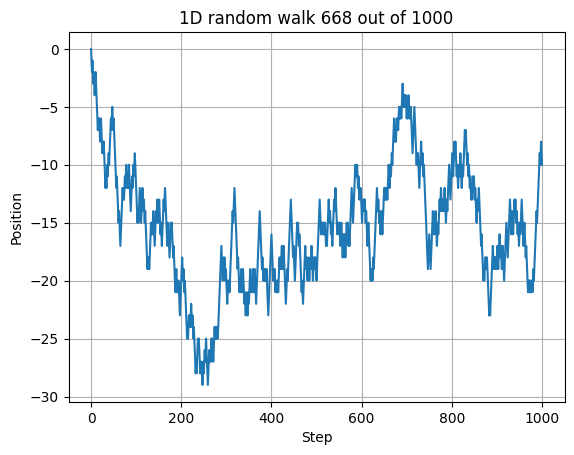

In [30]:
iexp = np.random.randint(0, Nexp) # For a random one
#iexp = max_experiment.argmin()   # For the walk with the smallest maximum distance
#iexp = max_experiment.argmax()   # For the walk with the largest maximum distance

plt.plot(walks[iexp,:])
plt.grid()
plt.xlabel('Step')
plt.ylabel('Position')
plt.title('1D random walk {0} out of {1}'.format(iexp, Nexp));
#plt.title('1D random walk with the smallest maximum distance ({0} out of {1})'.format(iexp, Nexp));
#plt.title('1D random walk with the largest maximum distance ({0} out of {1})'.format(iexp, Nexp));

### Animation of a specific walk

<IPython.core.display.Javascript object>


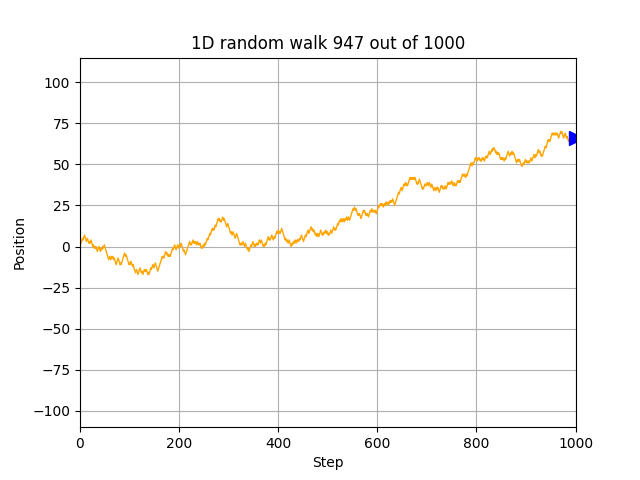

In [31]:
%matplotlib notebook

import matplotlib.animation as animation

# Randomly select a walk
iexp = np.random.randint(0, Nexp)

# Create a figure object
fig = plt.figure()

# Add subplot (just 1) and set x and y limits based on data.
# 111 means "1x1 grid, 1st subplot".
# ax is the object containing objects to be plotted.
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, Nsteps), ylim=(walks.min(), walks.max()))
ax.grid()
ax.set_xlabel('Step')
ax.set_ylabel('Position')
plt.title('1D random walk {0} out of {1}'.format(iexp, Nexp))

# 1. Plot the initial state of the plot
i = 0
path, *_ = ax.plot(i, walks[iexp, i], '-', lw=1, color='orange')
walker, *_ = ax.plot(i, walks[iexp, i], '>', lw=2, ms=10, color='blue')

# 2. Function to refresh objects in the plot
def refresh(i):
    # Draw the line from 0th -> i-th position
    path.set_data(range(i), walks[iexp,:i])
    # Draw the walker ONLY at the i-th position
    walker.set_data(i, walks[iexp,i])
    # Return a tuple
    return path, walker

# 3. Call the FuncAnimation function to redraw the 'fig' object using the 'refresh' function
ani = animation.FuncAnimation(fig, refresh, np.arange(1, Nsteps), interval=0.5, blit=True, repeat=False)

# With %matplotlib notebook, the following line is enough on my machine
plt.show()

# Here is the rendering that makes the animation work on Colab
# (and possibly other machines)
#from matplotlib import rc
# Try html='jshtml' if html='html5' fails
#rc('animation', html='html5')
#ani

### Static plot of all experiments

<IPython.core.display.Javascript object>


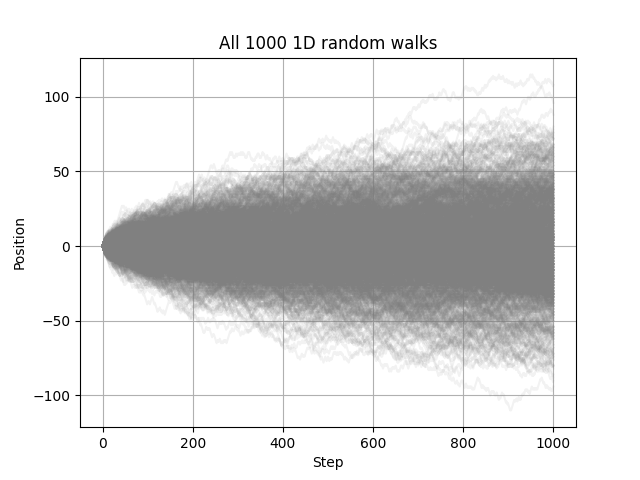

In [35]:
fig = plt.figure()

# For a color plot
#_ = [plt.plot(walks[i,:]) for i in range(Nexp)]
# For a B/W plot
_ = [plt.plot(walks[i,:], color='gray', alpha=0.1) for i in range(Nexp)]

plt.grid()
plt.xlabel('Step')
plt.ylabel('Position')
plt.title('All {0} 1D random walks'.format(Nexp));

### Distribution of distances

Note that we have to use `flatten()` to consider all the data together.

We look at distributions of
1. all distances,
1. final distances, and
1. maximum distances

both with sign and in absolute value

In [54]:
max_experiment_with_sign = list(zip(walks, np.abs(walks).argmax(axis=1)))
max_experiment_with_sign = np.array([i[0][i[1]] for i in max_experiment_with_sign])

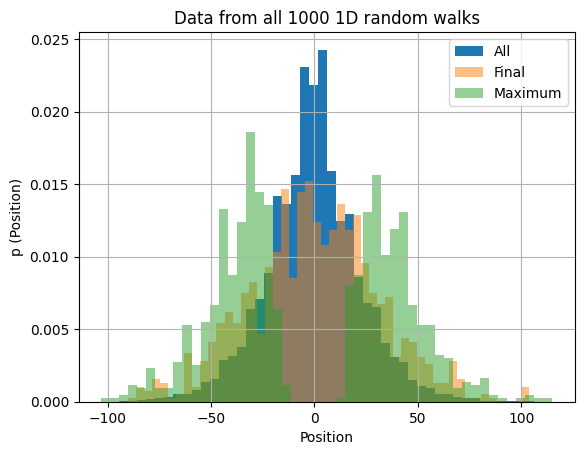

In [55]:
%matplotlib inline

import matplotlib.pyplot as plt

nbins = 50

plt.hist(walks.flatten(), bins=nbins, density=True, log=False, label='All')
plt.hist(walks[:,-1], bins=nbins, alpha=0.5, density=True, log=False, label='Final')
plt.hist(max_experiment_with_sign, bins=nbins, alpha=0.5, density=True, log=False, label='Maximum')

plt.grid()
plt.xlabel('Position')
plt.ylabel('p (Position)')
plt.legend()
plt.title('Data from all {0} 1D random walks'.format(Nexp));

Text(0.5, 1.0, 'Data from all 1000 1D random walks')

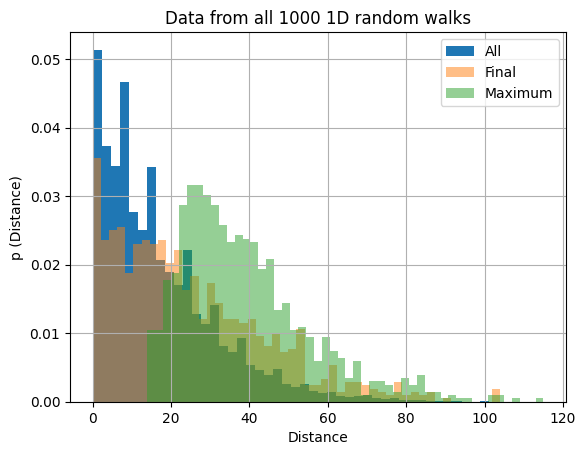

In [56]:
%matplotlib inline

import matplotlib.pyplot as plt

nbins = 50

plt.hist(np.abs(walks.flatten()), bins=nbins, density=True, log=False, label='All')
plt.hist(np.abs(walks[:,-1]), bins=nbins, alpha=0.5, density=True, log=False, label='Final')
plt.hist(max_experiment, bins=nbins, alpha=0.5, density=True, log=False, label='Maximum')

plt.grid()
plt.xlabel('Distance')
plt.ylabel('p (Distance)')
plt.legend()
plt.title('Data from all {0} 1D random walks'.format(Nexp))

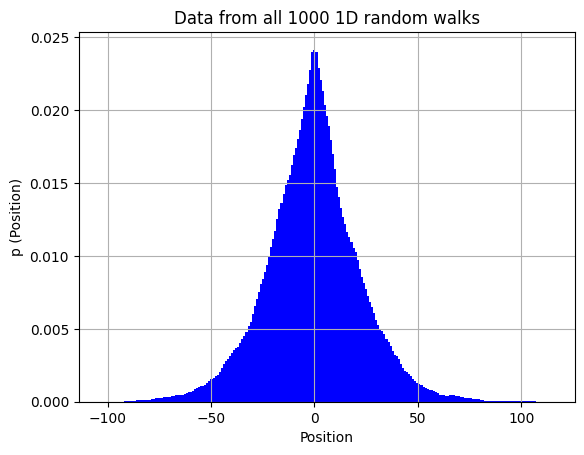

In [70]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.hist(walks[:,1:].flatten(), bins=int(2*max_experiment.max()-11), facecolor='blue', density=True, log=False)

plt.grid()
plt.xlabel('Position')
plt.ylabel('p (Position)')
plt.title('Data from all {0} 1D random walks'.format(Nexp));

### Animation of all walks

<IPython.core.display.Javascript object>


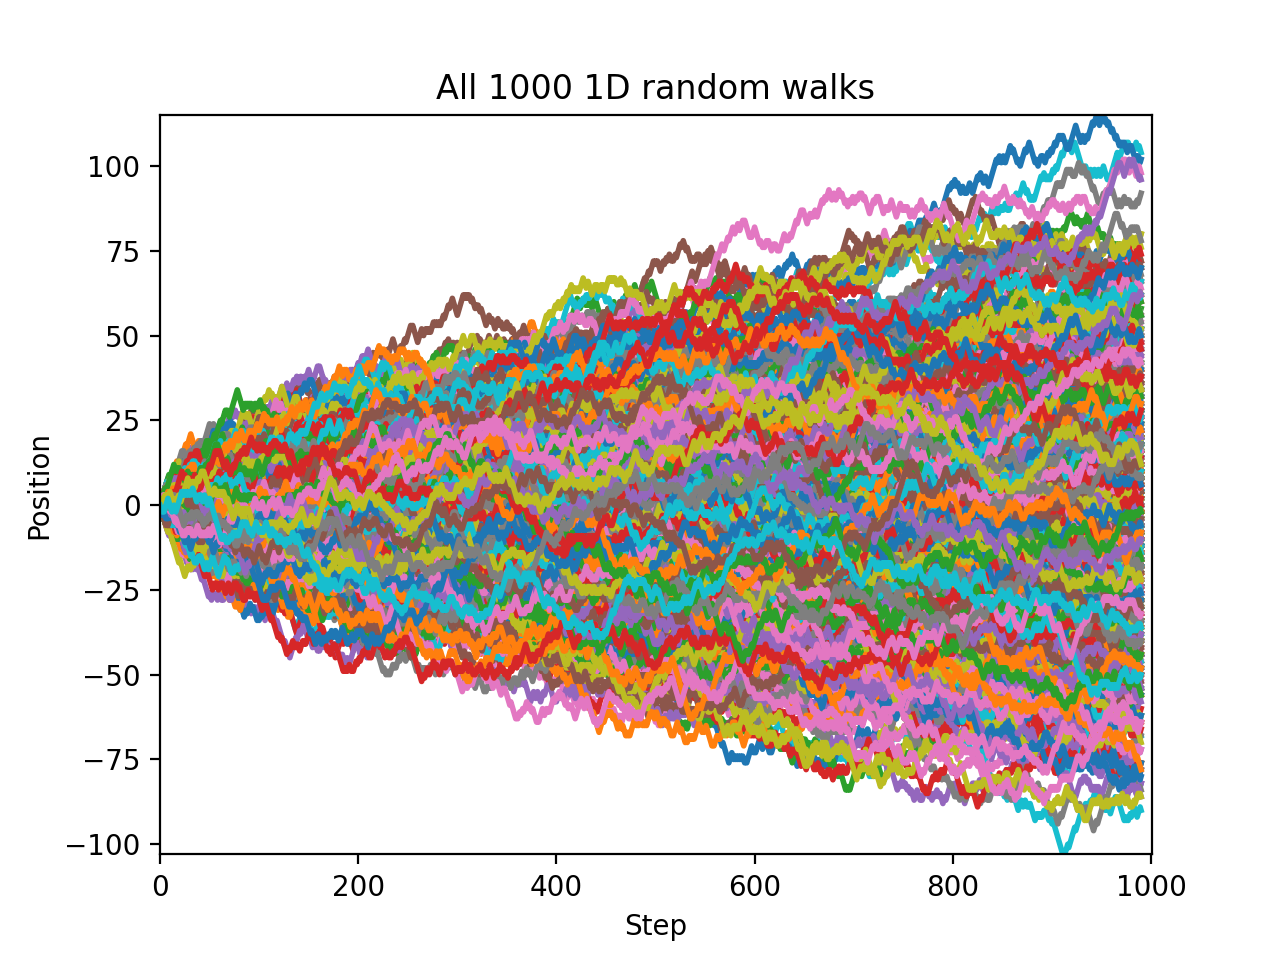

In [73]:
%matplotlib notebook

import matplotlib.animation as animation

# Create a figure object
fig = plt.figure()

# Add subplot (just 1) and set x and y limits based on data.
# 111 means "1x1 grid, 1st subplot".
# ax is the object containing objects to be plotted.
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, Nsteps), ylim=(walks.min(), walks.max()))
ax.grid()
ax.set_xlabel('Step')
ax.set_ylabel('Position')
plt.title('{0} 1D random walks'.format(Nexp))

# 1. Plot the initial state of the plot
i = 0
paths = []
for j in range(Nexp):
    # For a color plot
    path, *_ = ax.plot(i, walks[j, i], '-', lw=2)
    # For a B/W plot
    #path, *_ = ax.plot(i, walks[j, i], color='gray', alpha=0.1)
    paths.append(path)#, color='orange')

plt.grid()
plt.xlabel('Step')
plt.ylabel('Position')
plt.title('All {0} 1D random walks'.format(Nexp))

# 2. Function to refresh objects in the plot
def refresh(i):
    # Draw all Nexp lines from 0th -> i-th position
    for j in range(Nexp):
        paths[j].set_data(range(i), walks[j,:i])
    # Return a tuple
    return paths, 

# 3. Call the FuncAnimation function to redraw the 'fig' object using the 'refresh'
ani = animation.FuncAnimation(fig, refresh, np.arange(1, Nsteps-1, 10), interval=1, blit=True, repeat=False)

# With %matplotlib notebook, the following line is enough on my machine
# Here we only get the first frame, so we do something additional in the next cell
plt.show()

# Here is the rendering that makes the animation work on Colab
# (and possibly other machines)
#from matplotlib import rc
# Try html='jshtml' if html='html5' fails
#rc('animation', html='html5')
#ani

## 3D Random Walk

This time we will have `axis=0` for the walkers, `axis=1` for their steps, and `axis=2` with 3 entries for $x$, $y$, and $z$.  Note that in 3D the distance from the origin requires evaluating $\sqrt{x^2+y^2+z^2}$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Nexp = 1000
Nsteps = 1000
# To experiment with adding Gaussian noise, change the value below
Noise = 0

options = np.array((-1, 0, 1))
steps = np.random.choice(options, size=(Nexp, Nsteps, 3)) + Noise * np.random.standard_normal((Nexp, Nsteps, 3))
print(steps.shape)

(1000, 1000, 3)


We can also think of generating each unit step in a random direction.

The first one is a slow C-like version.  The second version fully exploits NumPy and its arrays: it is **a lot faster**.

In [3]:
%%time

def unit_step_random_direction():
    phi = np.random.uniform(0,np.pi*2)
    costheta = np.random.uniform(-1,1)

    theta = np.arccos(costheta)
    sintheta = np.sin(theta)
    x = sintheta*np.cos(phi)
    y = sintheta*np.sin(phi)
    z = costheta
    return np.array([x,y,z])


steps = np.array([[list(unit_step_random_direction()) for j in range(Nsteps)] for i in range(Nexp)])
print(steps.shape)

(1000, 1000, 3)
CPU times: user 4.74 s, sys: 64.7 ms, total: 4.81 s
Wall time: 4.82 s


In [4]:
%%time

def walk_with_random_direction(Nexp, Nsteps):
    phi = np.random.uniform(0,np.pi*2, (Nexp, Nsteps))
    costheta = np.random.uniform(-1,1, (Nexp, Nsteps))

    theta = np.arccos(costheta)
    sintheta = np.sin(theta)
    x = sintheta*np.cos(phi)
    y = sintheta*np.sin(phi)
    z = costheta
    walks = np.array(list(zip(x,y,z)))
    walks = walks.transpose([0, 2, 1])
    return walks

steps = walk_with_random_direction(Nexp, Nsteps)
print(steps.shape)

(1000, 1000, 3)
CPU times: user 74.2 ms, sys: 11 ms, total: 85.3 ms
Wall time: 82 ms


We call `cumsum(axis=1)` to sum (cumulatively) over the dimension 1, i.e., the steps of each walk in 3D.  Then we prepend the origin as a starting position.

In [7]:
walks = steps.cumsum(axis=1)
print(walks.shape)
print(walks[0,0])

walks = np.insert(walks, 0, 0, axis=1)
print(walks.shape)
print(walks[0,0])

Nsteps = Nsteps + 1

(1000, 1000, 3)
[ 0.94472508  0.32382015 -0.05133256]
(1000, 1001, 3)
[0. 0. 0.]


Use `numpy.linalg.norm` to compute distances.  This is done along `axis=2`, which contains the $(x,y,z)$ for a given walker at a given time.

In [9]:
%%time

from numpy.linalg import norm

distances = norm(walks, axis=2)
distances.shape

CPU times: user 24.2 ms, sys: 6.01 ms, total: 30.2 ms
Wall time: 27.8 ms


(1000, 1001)

The maximum distance (from the origin) ever reached in all experiments is:

In [10]:
distances.max()

77.77212702431919

We can also find out the maximum distance for each experiment. This is done by using the [`numpy.amax`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.amax.html) function. We want to find the maximum along columns (`axis=1`) for each experiment (row, or `axis=0`).

In [11]:
max_experiment = np.amax(distances, 1)
print(max_experiment.shape)

(1000,)


As a sanity check, we see that the maximum distance across experiments is the same as the value returned by `np.abs(walks).max()`:

In [12]:
print("Max ever: {0}. This occurred in experiment: {1}".format(
    max_experiment.max(), max_experiment.argmax()))
distances.max()

Max ever: 77.77212702431919. This occurred in experiment: 184


77.77212702431919

The following is tells us in which experiments it was reached:

In [13]:
np.where(max_experiment==max_experiment.max())

(array([184]),)

Similarly the smallest maximum distance ever reached is

In [14]:
max_experiment.min()

14.155498391232854

This occured in experiments:

In [15]:
np.where(max_experiment==max_experiment.min())

(array([779]),)

### Distribution of distances

Note that we have to use `flatten()` to consider all the data together.

We look at distributions of
1. all distances,
1. final distances, and
1. maximum distances.

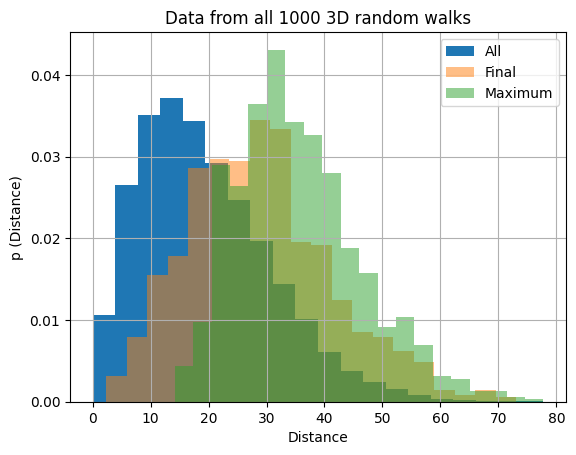

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

nbins = 20

plt.hist(distances.flatten(), bins=nbins, density=True, log=False, label='All')
plt.hist(distances[:,-1], bins=nbins, alpha=0.5, density=True, log=False, label='Final')
plt.hist(max_experiment, bins=nbins, alpha=0.5, density=True, log=False, label='Maximum')

plt.grid()
plt.xlabel('Distance')
plt.ylabel('p (Distance)')
plt.legend()
plt.title('Data from all {0} 3D random walks'.format(Nexp));

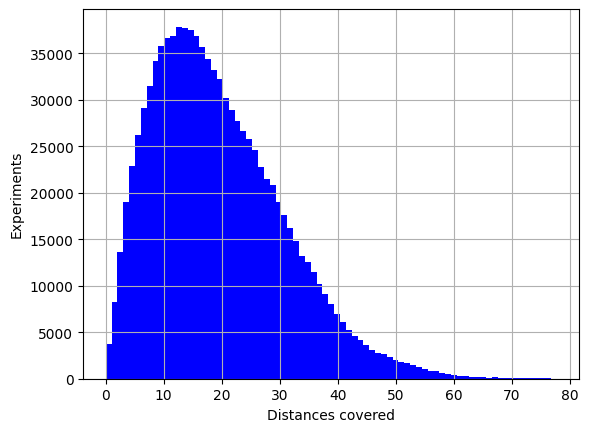

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(distances.flatten(), bins=int(distances.max() - distances.min()), facecolor='blue', density=False, log=False)

plt.grid()
plt.xlabel('Distances covered')
plt.ylabel('Experiments');

### Plot a specific walk chosen randomly

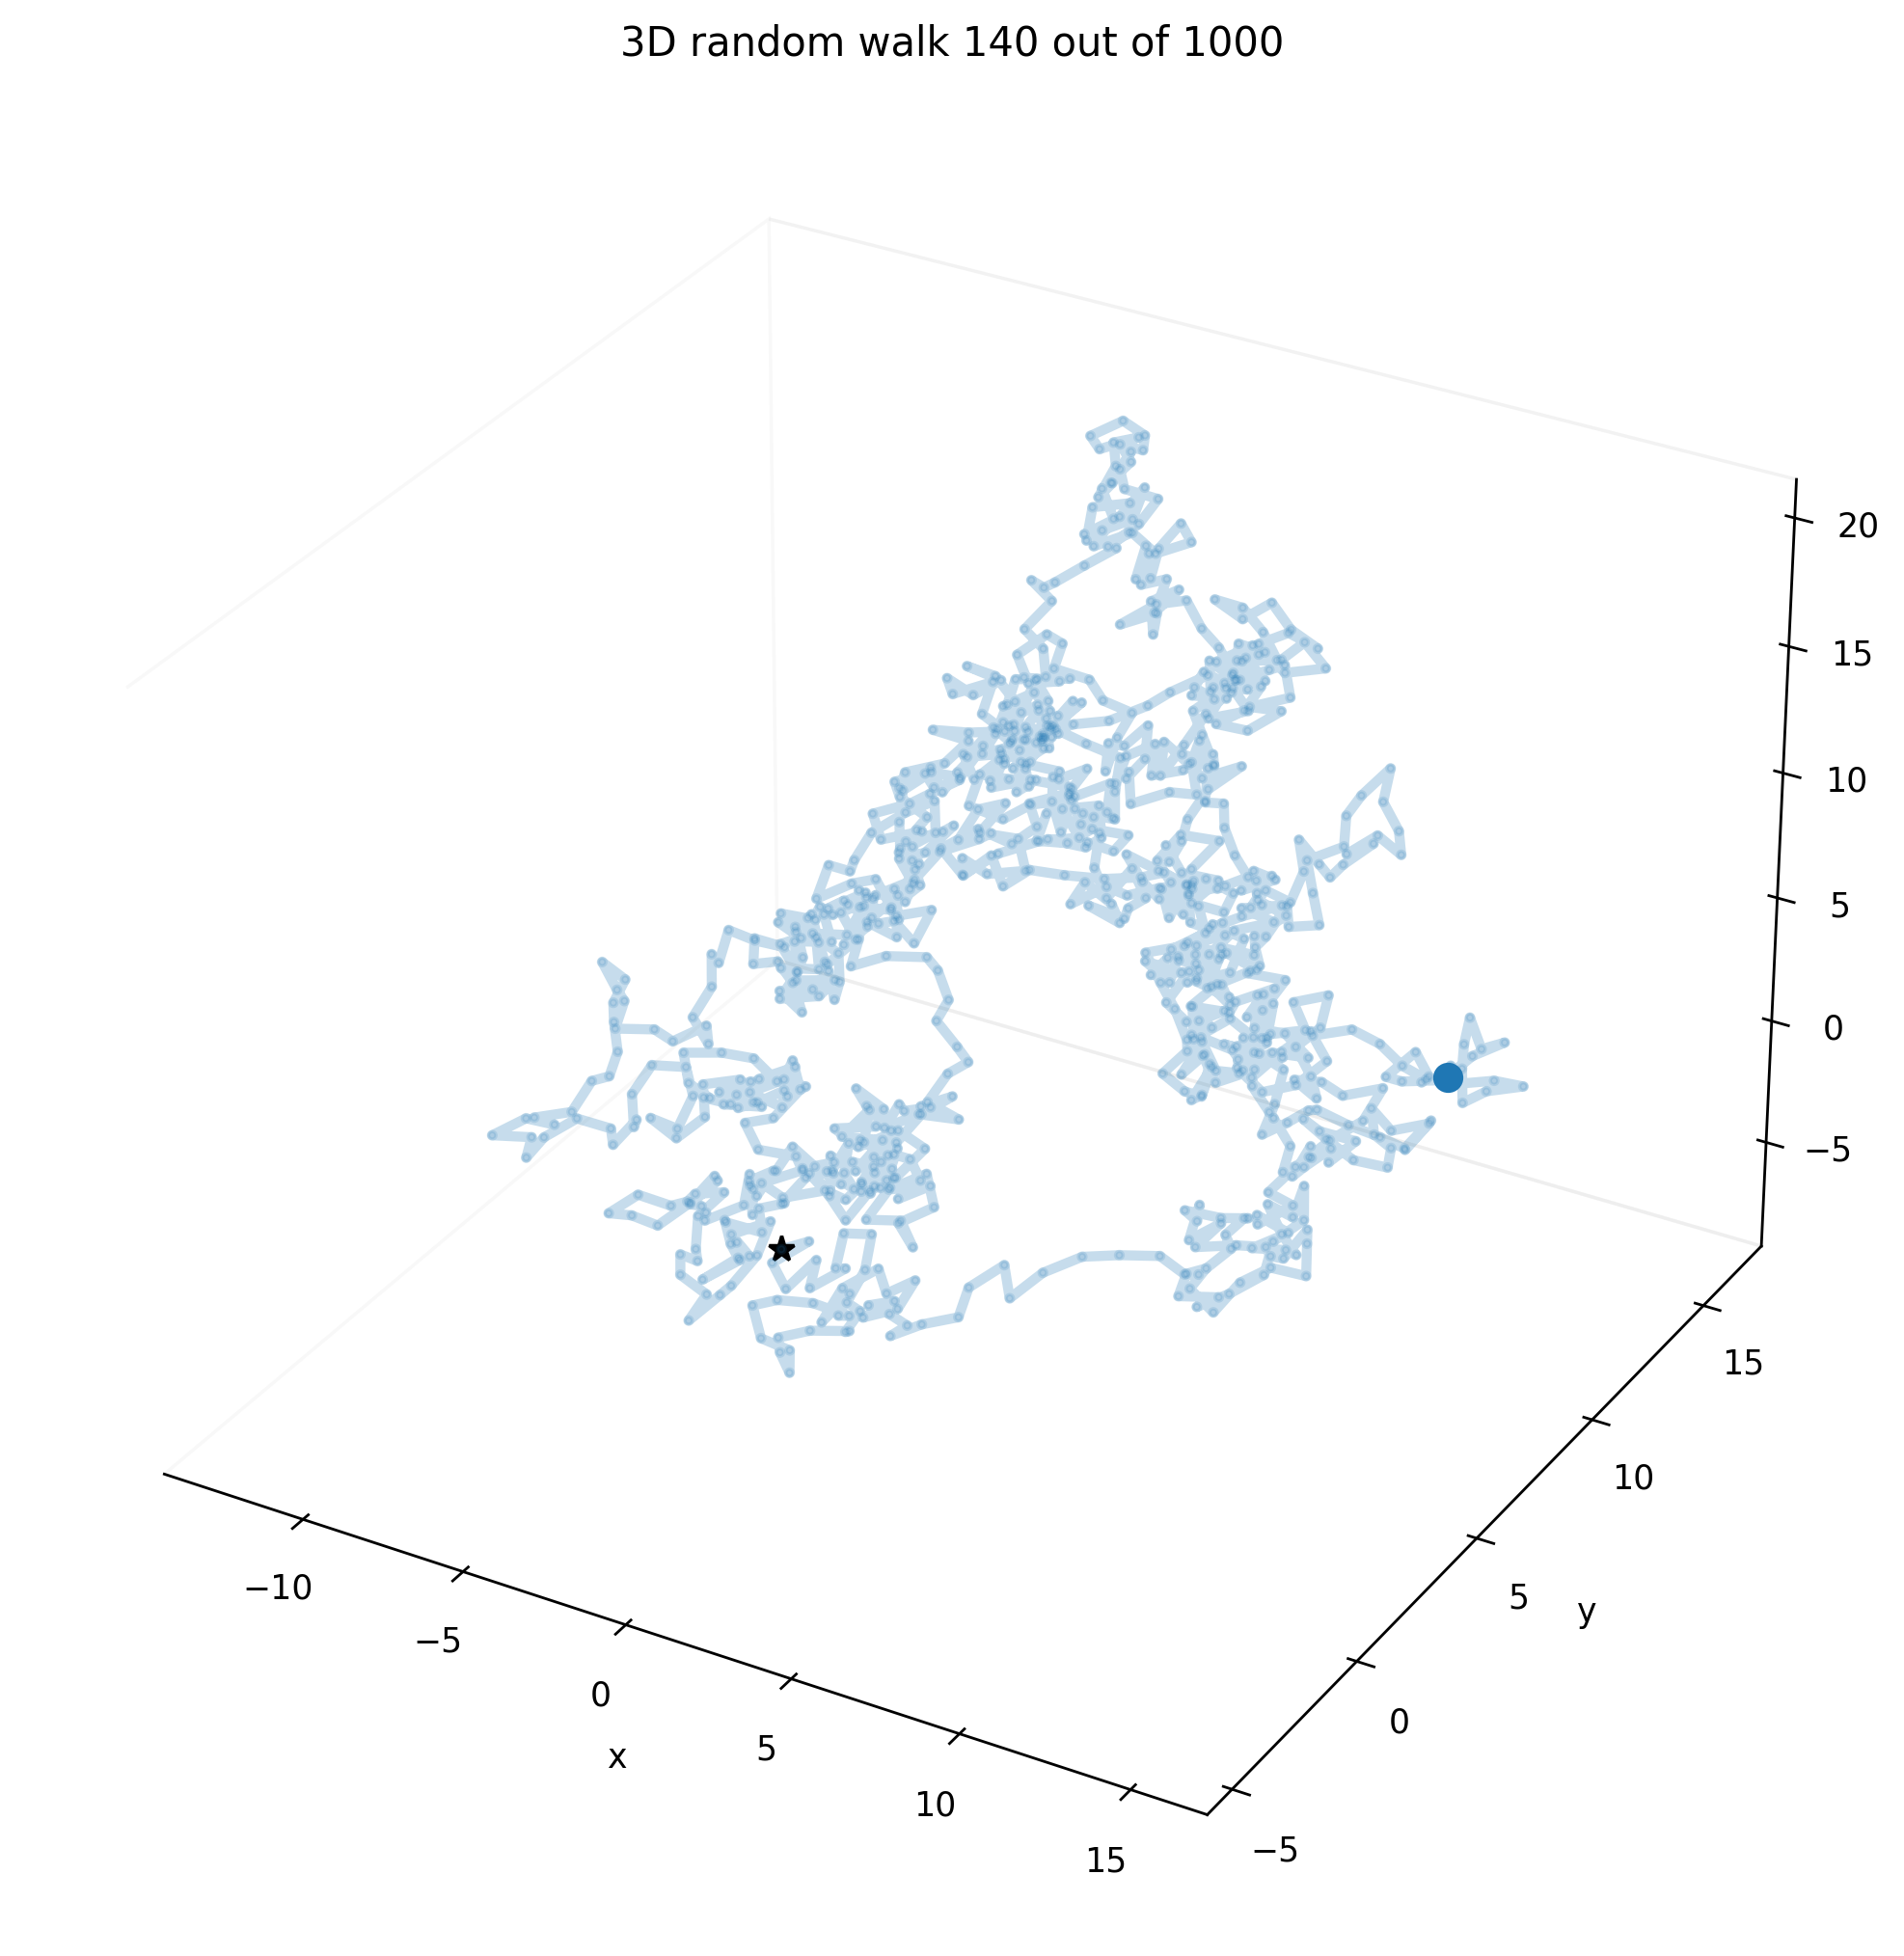

In [20]:
%matplotlib inline

# Randomly select a walk
iexp = np.random.randint(0, Nexp)

fig = plt.figure(figsize=(10,10),dpi=250)
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter3D(walks[iexp,:,0], walks[iexp,:,1], walks[iexp,:,2], alpha=0.15, s=5)
p = ax.plot3D(walks[iexp,:,0], walks[iexp,:,1], walks[iexp,:,2], alpha=0.25, lw=3)
col = p[0].get_color()
ax.plot3D(walks[iexp,-1,0], walks[iexp,-1,1], walks[iexp,-1,2], color=col, marker='o', ms=8)
ax.plot3D(walks[iexp,0,0], walks[iexp,0,1], walks[iexp,0,2], marker='*', ms=8, color='k')

plt.title('3D random walk {0} out of {1}'.format(iexp, Nexp));

### Plot all walks

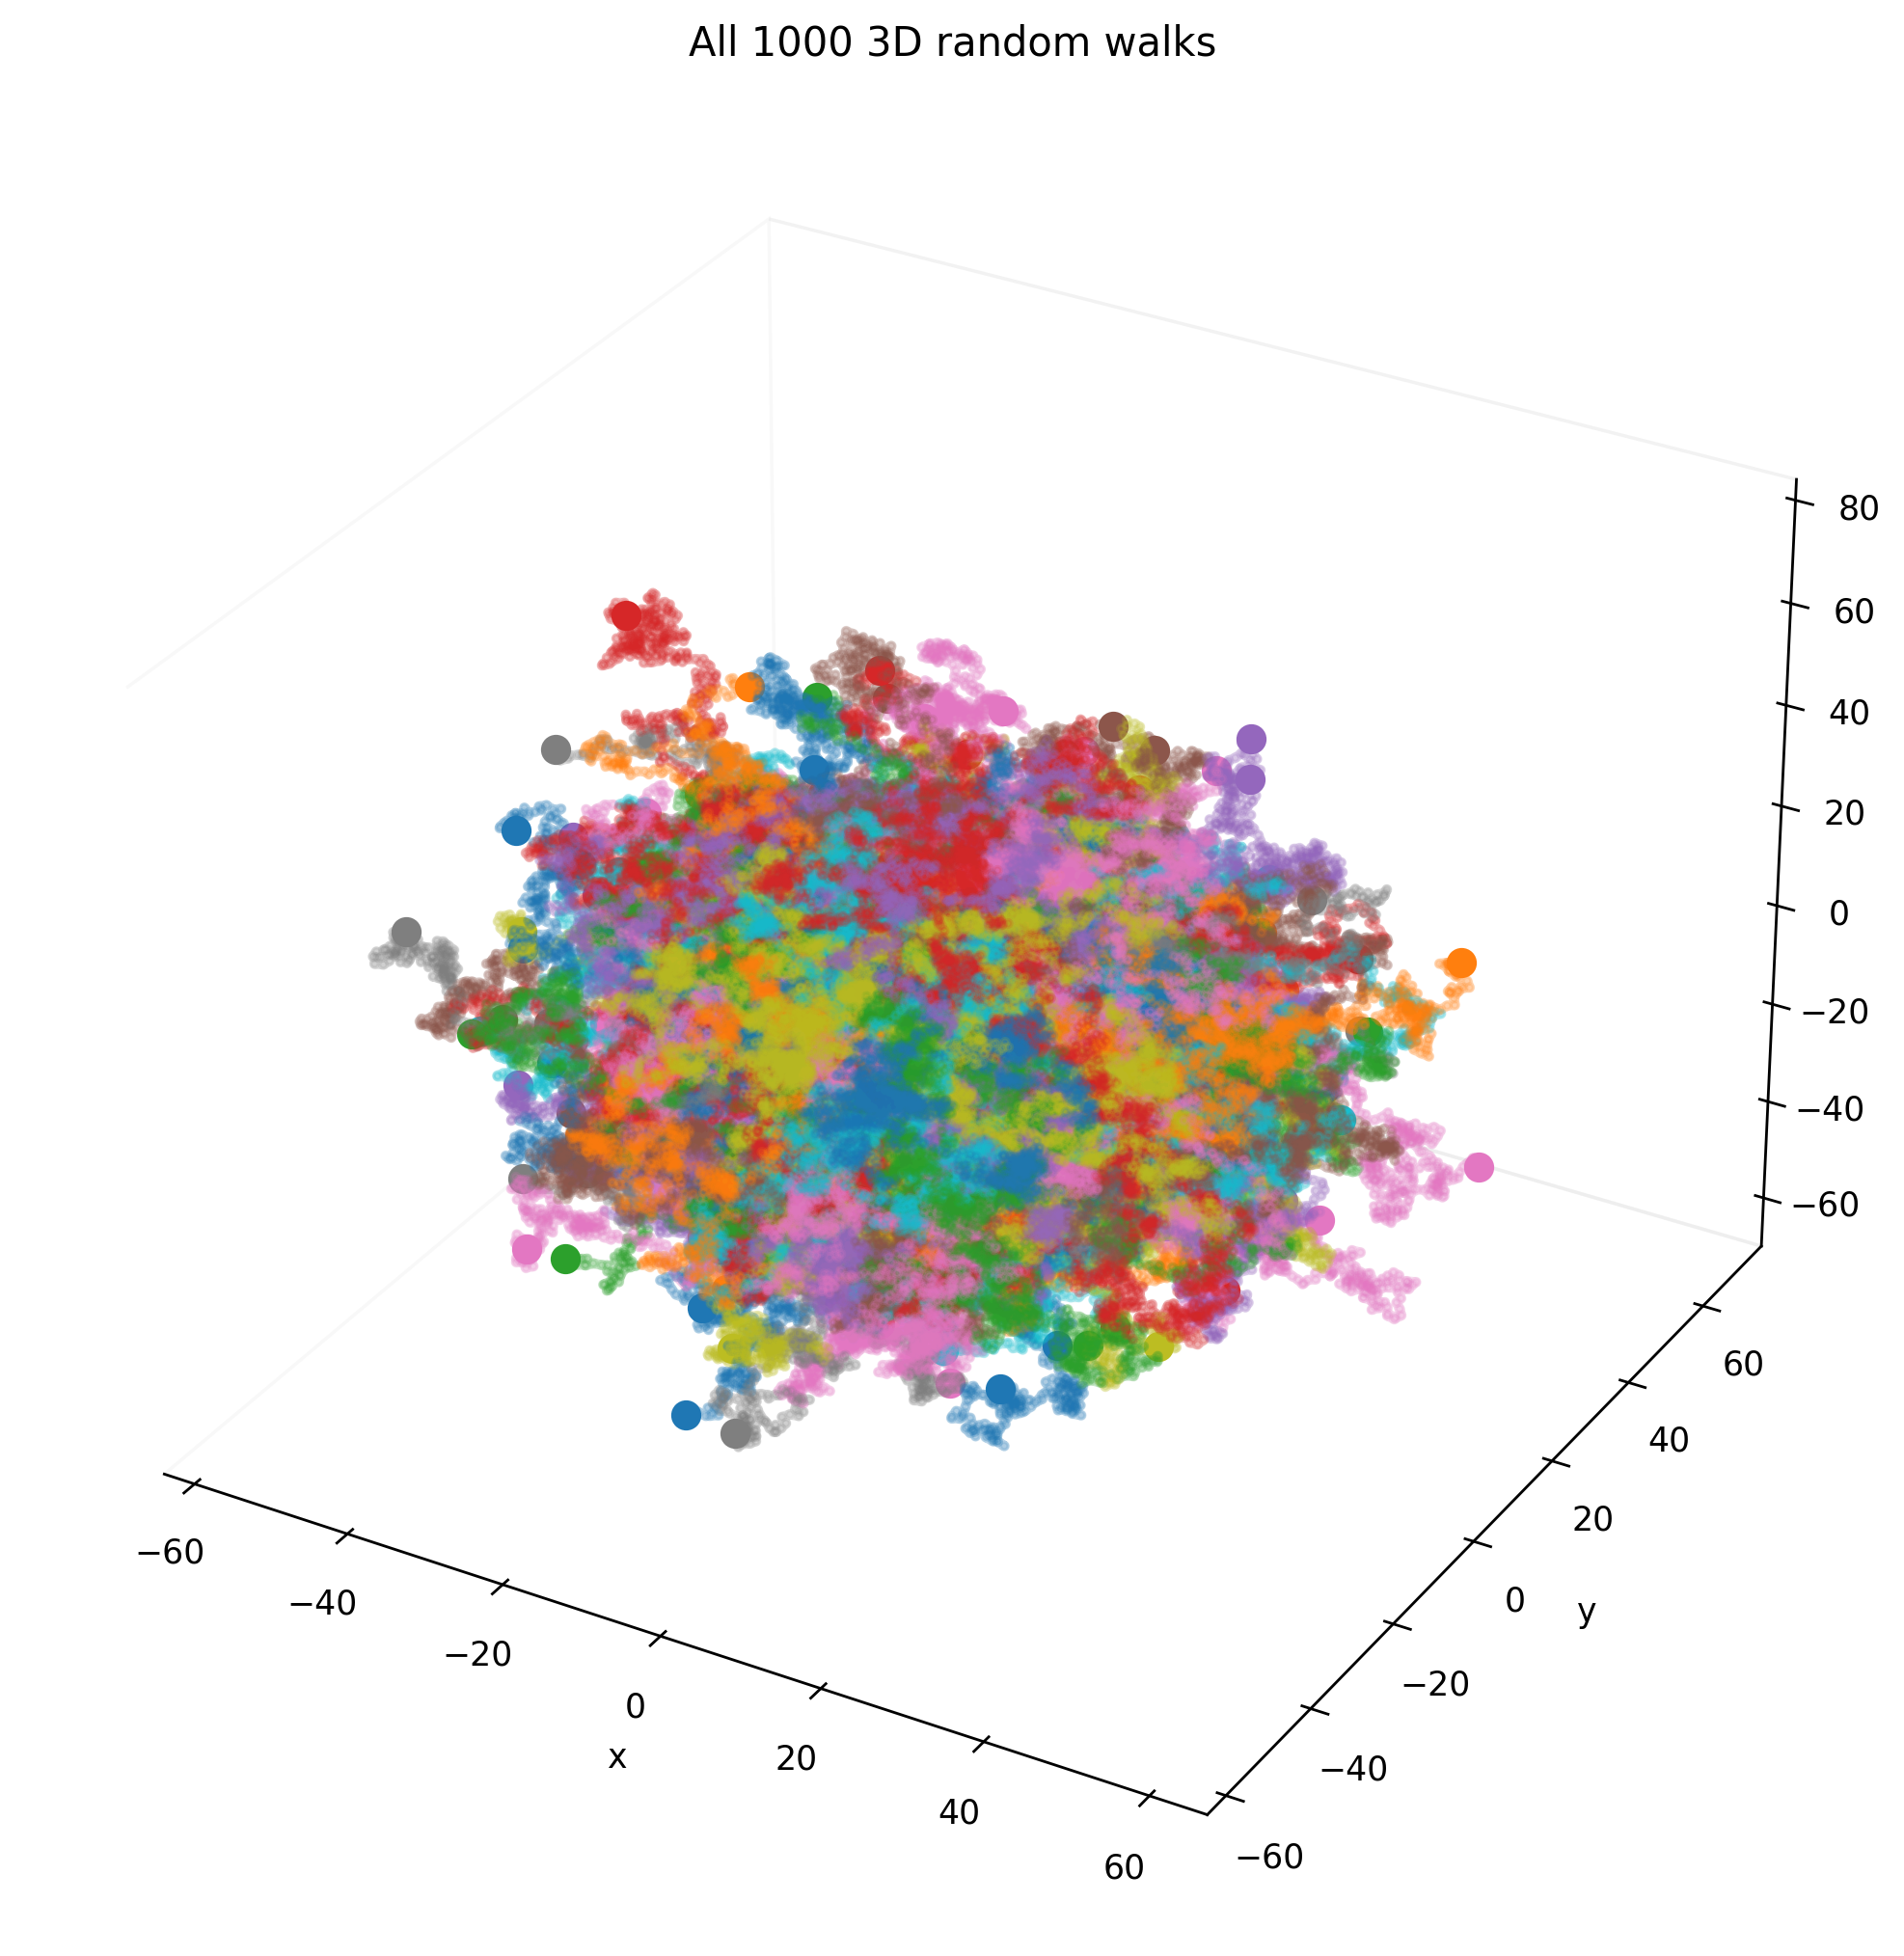

In [21]:
fig = plt.figure(figsize=(10,10),dpi=250)

# Add subplot (just 1) and set x and y limits based on data.
# 111 means "1x1 grid, 1st subplot".
# ax is the object containing objects to be plotted.
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for iexp in range(0, Nexp, 1):
    ax.scatter3D(walks[iexp,:,0], walks[iexp,:,1], walks[iexp,:,2], alpha=0.15, s=5)
    p = ax.plot3D(walks[iexp,:,0], walks[iexp,:,1], walks[iexp,:,2], alpha=0.25, lw=3)
    col = p[0].get_color()
    ax.plot3D(walks[iexp,-1,0], walks[iexp,-1,1], walks[iexp,-1,2], color=col, marker='o', ms=8)
ax.plot3D(walks[iexp,0,0], walks[iexp,0,1], walks[iexp,0,2], color='k', marker='*', ms=8)

plt.title('All {0} 3D random walks'.format(Nexp));

### Animated plot of a random walk

<IPython.core.display.Javascript object>


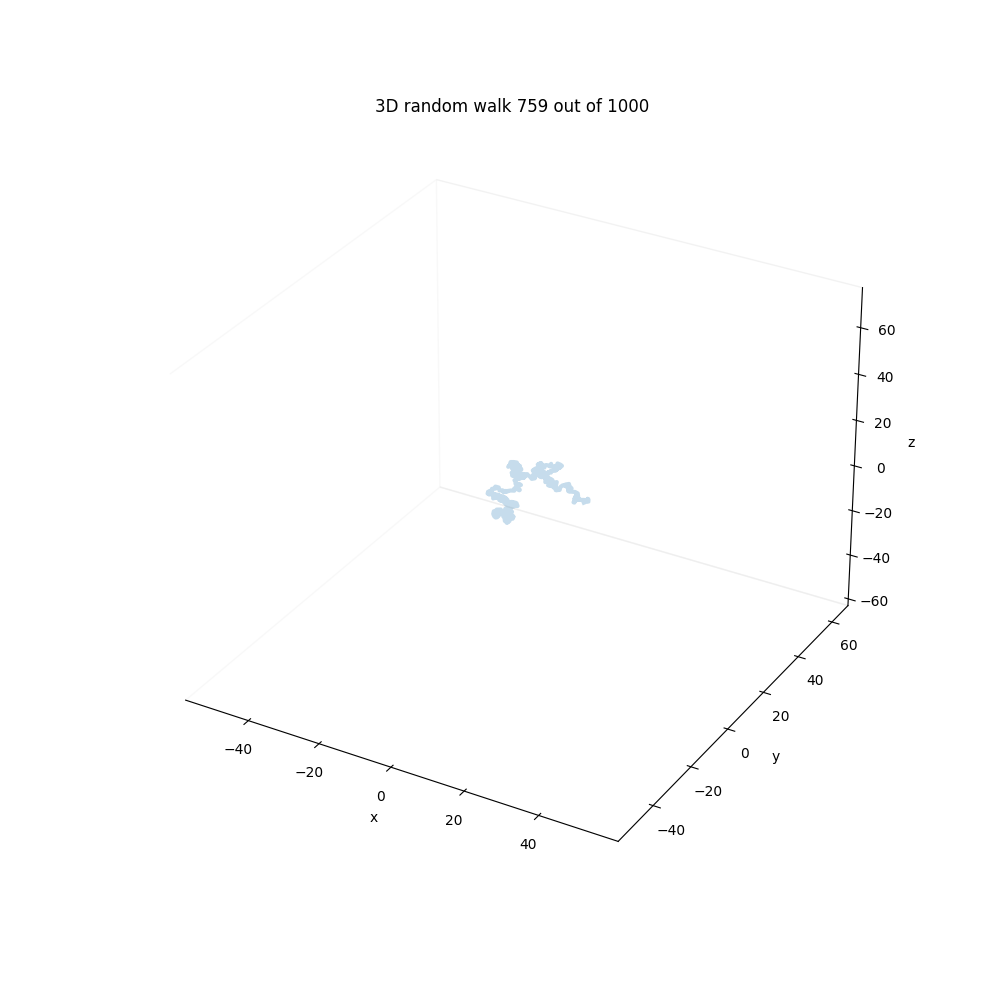

In [22]:
%matplotlib notebook

import matplotlib.animation as animation

# Randomly select a walk
iexp = np.random.randint(0, Nexp)

# Create a figure object
fig = plt.figure(figsize=(10,10))

# Add subplot (just 1) and set x and y limits based on data.
# 111 means "1x1 grid, 1st subplot".
# ax is the object containing objects to be plotted.
ax = fig.add_subplot(111, projection='3d', autoscale_on=False)
ax.set_xlim(walks[:,:,0].min(), walks[:,:,0].max())
ax.set_ylim(walks[:,:,1].min(), walks[:,:,1].max())
ax.set_zlim(walks[:,:,2].min(), walks[:,:,2].max())
ax.grid(False)
ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('3D random walk {0} out of {1}'.format(iexp, Nexp))

# 1. Plot the initial state of the plot
i = 0
path, *_ = ax.plot3D(walks[iexp,i,0], walks[iexp,i,1], walks[iexp,i,2], alpha=0.25, lw=3)

# 2. Function to refresh objects in the plot
def refresh(i):
    # Draw the line from 0th -> i-th position
    path.set_data_3d(walks[iexp,:i,0], walks[iexp,:i,1], walks[iexp,:i,2])
    # Return a tuple
    return path,

# 3. Call the FuncAnimation function to redraw the 'fig' object using the 'refresh' function
ani = animation.FuncAnimation(fig, refresh, np.arange(1, Nsteps), interval=1, blit=True, repeat=True)

# With %matplotlib notebook, the following line is enough on my machine
# Here we only get the first frame, so we do something additional in the next cell
plt.show()

# Here is the rendering that makes the animation work on Colab
# (and possibly other machines)
#from matplotlib import rc
# Try html='jshtml' if html='html5' fails
#rc('animation', html='html5')
#ani

### Animation of all walks

<IPython.core.display.Javascript object>


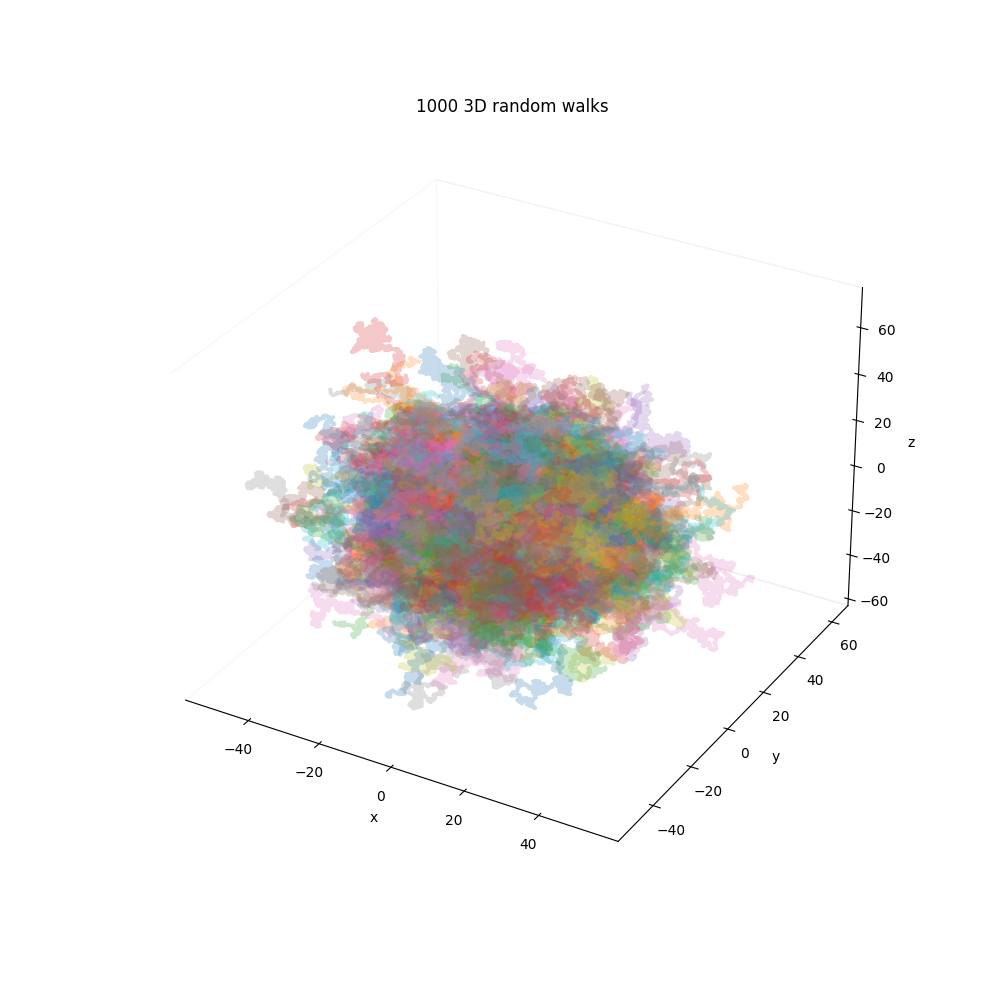

In [23]:
#%matplotlib inline
%matplotlib notebook

# Randomly select a walk
iexp = np.random.randint(0, Nexp)

# Create a figure object
fig = plt.figure(figsize=(10,10))

# Add subplot (just 1) and set x and y limits based on data.
# 111 means "1x1 grid, 1st subplot".
# ax is the object containing objects to be plotted.
ax = fig.add_subplot(111, projection='3d', autoscale_on=False)
ax.set_xlim(walks[:,:,0].min(), walks[:,:,0].max())
ax.set_ylim(walks[:,:,1].min(), walks[:,:,1].max())
ax.set_zlim(walks[:,:,2].min(), walks[:,:,2].max())
ax.grid(False)
ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('{0} 3D random walks'.format(Nexp))

# 1. Plot the initial state of the plot
i = 0
paths = []
for j in range(Nexp):
    path, *_ = ax.plot3D(walks[j,i,0], walks[j,i,1], walks[j,i,2], alpha=0.25, lw=3)
    paths.append(path)#, color='orange')

# 2. Function to refresh objects in the plot
def refresh(i):
    # Draw all Nexp lines from 0th -> i-th position
    for j in range(Nexp):
        paths[j].set_data_3d(walks[j,:i,0], walks[j,:i,1], walks[j,:i,2])
    # Return a tuple
    return paths, 
    
# 3. Call the FuncAnimation function to redraw the 'fig' object using the 'refresh' function
ani = animation.FuncAnimation(fig, refresh, np.arange(1, Nsteps), interval=1, blit=True, repeat=False)

# With %matplotlib notebook, the following line is enough on my machine
# Here we only get the first frame, so we do something additional in the next cell
plt.show()

# Here is the rendering that makes the animation work on Colab
# (and possibly other machines)
#from matplotlib import rc
# Try html='jshtml' if html='html5' fails
#rc('animation', html='html5')
#ani

### Alternative animation of all walks

<IPython.core.display.Javascript object>


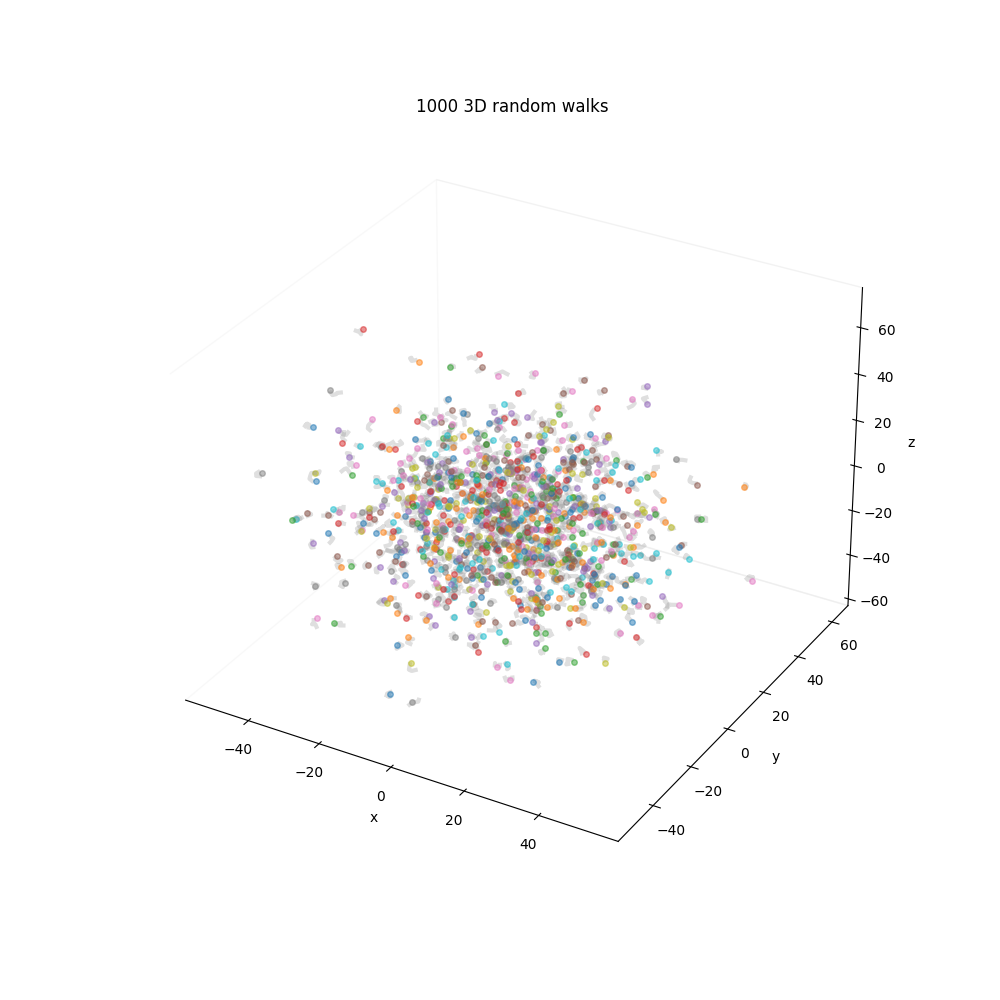

In [24]:
#%matplotlib inline
%matplotlib notebook

# Randomly select a walk
iexp = np.random.randint(0, Nexp)

# Create a figure object
fig = plt.figure(figsize=(10,10))

# Add subplot (just 1) and set x and y limits based on data.
# 111 means "1x1 grid, 1st subplot".
# ax is the object containing objects to be plotted.
ax = fig.add_subplot(111, projection='3d', autoscale_on=False)
ax.set_xlim(walks[:,:,0].min(), walks[:,:,0].max())
ax.set_ylim(walks[:,:,1].min(), walks[:,:,1].max())
ax.set_zlim(walks[:,:,2].min(), walks[:,:,2].max())
ax.grid(False)
ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('{0} 3D random walks'.format(Nexp))

# 1. Plot the initial state of the plot
i = 0
paths = []
particles = []
for j in range(Nexp):
    path, *_ = ax.plot3D(walks[j,i,0], walks[j,i,1], walks[j,i,2], alpha=0.25, lw=3, color='gray')
    paths.append(path)
    particle, *_ = ax.plot3D(walks[j,i,0], walks[j,i,1], walks[j,i,2], 'o', alpha=0.5, markersize=4)
    particles.append(particle)

# 2. Function to refresh objects in the plot
ihist = 5
def refresh(i):
    # Draw all Nexp lines from the i-th to the (i+ihist)-th position
    for j in range(Nexp):
        paths[j].set_data_3d(walks[j,i:i+ihist,0], walks[j,i:i+ihist,1], walks[j,i:i+ihist,2])
        particles[j].set_data_3d(walks[j,i+ihist,0], walks[j,i+ihist,1], walks[j,i+ihist,2])
    # Return a tuple
    return paths, particles
    
# 3. Call the FuncAnimation function to redraw the 'fig' object using the 'refresh' function
ani = animation.FuncAnimation(fig, refresh, np.arange(1, Nsteps-ihist), interval=1, blit=True, repeat=False)

# With %matplotlib notebook, the following line is enough on my machine
# Here we only get the first frame, so we do something additional in the next cell
plt.show()

# Here is the rendering that makes the animation work on Colab
# (and possibly other machines)
#from matplotlib import rc
# Try html='jshtml' if html='html5' fails
#rc('animation', html='html5')
#ani